# Deploying Drift Detection

TorchDrift provides the tools you need to detect drift. But how do you actually get your model to monitor drift?
This short tutorial shows how to use model hooks on your feature extractor to capture data to feed into the drift detector.


In [1]:
import sys
sys.path.insert(0, '../')

import torch
import torchvision
import torchdrift
import copy
%matplotlib inline
from matplotlib import pyplot


device = "cuda"

In [2]:
model = torchvision.models.resnet18(pretrained=True)
model.eval().to(device)
for p in model.parameters():
    p.requires_grad_(False)

    
    
detector = torchdrift.detectors.KernelMMDDriftDetector()



In [3]:
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor()])

def normalize(x):
    return torchvision.transforms.functional.normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

ds_train = torchvision.datasets.ImageFolder('./data/hymenoptera_data/train/',
                                            transform=val_transform)
ds_val = torchvision.datasets.ImageFolder('./data/hymenoptera_data/val/',
                                          transform=val_transform)



def fit_detector(N_train):
    feature_extractor = copy.deepcopy(model)
    feature_extractor.fc = torch.nn.Identity()
    ref_input = normalize(torch.stack([ds_train[i][0] for i in torch.randperm(len(ds_train))[:N_train]]).cuda())
    ref_features = feature_extractor(ref_input)

    detector.fit(ref_features)

fit_detector(N_train = 100)

In [4]:
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=64, shuffle=True)

In [5]:
class ModelMonitor:
    def __init__(self, drift_detector, feature_layer, N = 20, callback = None, callback_interval = 1):
        self.N = N
        base_outputs = drift_detector.base_outputs
        self.drift_detector = drift_detector
        assert base_outputs is not None, "fit drift detector first"
        feature_dim = base_outputs.size(1)
        self.feature_rb = torch.zeros(N, feature_dim, device=base_outputs.device, dtype=base_outputs.dtype)
        self.have_full_round = False
        self.next_idx = 0
        self.hook = feature_layer.register_forward_hook(self.collect_hook)
        self.counter = 0
        self.callback = callback
        self.callback_interval = callback_interval

    def unhook(self):
        self.hook.remove()

    def collect_hook(self, module, input, output):
        self.counter += 1
        bs = output.size(0)
        if bs > self.N:
            output = output[-self.N:]
            bs = self.N
        output = output.reshape(bs, -1)
        first_part = min(self.N - self.next_idx, bs)
        self.feature_rb[self.next_idx: self.next_idx + first_part] = output[:first_part]
        if first_part < bs:
            self.feature_rb[: bs - first_part] = self.output[first_part:]
        if not self.have_full_round and self.next_idx + bs >= self.N:
            self.have_full_round = True
        self.next_idx = (self.next_idx + bs) % self.N
        if self.callback and self.have_full_round and self.counter % self.callback_interval == 0:
            p_val = self.drift_detector.compute_p_value(self.feature_rb)
            self.callback(p_val)

    def plot(self):
        import sklearn.manifold
        from matplotlib import pyplot
        
        mapping = sklearn.manifold.Isomap()
        ref = mapping.fit_transform(self.drift_detector.base_outputs.to("cpu").numpy())

        test = mapping.transform(self.feature_rb.to("cpu").numpy())
        pyplot.scatter(ref[:, 0], ref[:, 1])
        pyplot.scatter(test[:, 0], test[:, 1])

def alarm(p_value):
    assert p_value > 0.01, "Drift alarm!"
    
mm = ModelMonitor(detector, model.avgpool, callback=alarm)


In [6]:
it = iter(dl_val)
batch = normalize(next(it)[0].to(device))

batch_drifted = normalize(torchdrift.data.functional.gaussian_blur(next(it)[0].to(device), 5))


In [7]:
model(batch)


tensor([[-7.7658e-01,  3.2179e+00, -1.2249e+00,  ...,  2.8282e-01,
          2.9029e-01,  2.1828e-03],
        [-1.8817e+00, -2.9643e-01,  1.5383e+00,  ..., -1.5474e+00,
         -3.7729e-01, -4.0559e-01],
        [-3.1957e+00,  1.1587e+00, -2.6124e+00,  ...,  1.4362e+00,
          3.8517e+00, -2.6117e-01],
        ...,
        [-6.0883e-01,  1.3820e+00, -4.6136e-01,  ..., -2.2287e+00,
         -8.9745e-01, -1.1200e-02],
        [ 2.7868e+00,  1.8231e+00,  1.7386e+00,  ...,  1.0247e+00,
          2.8079e+00, -6.6821e-01],
        [ 7.4745e-01,  2.8122e+00,  1.0374e+00,  ...,  1.6652e+00,
         -5.1658e-01,  8.6155e-01]], device='cuda:0')

In [8]:
detector.compute_p_value(mm.feature_rb)

tensor(0.7140, device='cuda:0')

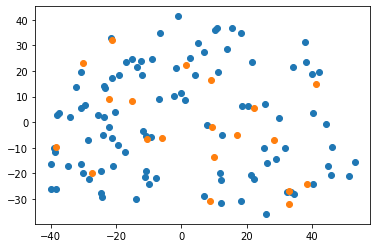

In [9]:
mm.plot()

In [10]:
# call it with drifted inputs...
model(batch_drifted)

AssertionError: Drift alarm!

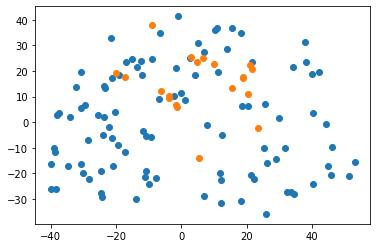

In [11]:
mm.plot()